# 라이브러리 설치

- 양자화, 실행 최적화, 효율적 파인튜닝, 데이터셋 처리, 시각화 라이브러리 불러오기

In [ ]:
!pip install -q -U bitsandbytes accelerate peft datasets tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.0/411.0 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# HuggingFace 로그인 및 데이터 업로드

- 구글 드라이브를 마운트해서 데이터를 불러오는 방식이 아닌 HuggingFace에 업로드해서 다시 불러오는 방식으로 데이터 사용

In [ ]:
# HuggingFace hub에 업로드하기 위해 인증 토큰으로 로그인
from huggingface_hub import login

login(token="token")

In [ ]:
import os
import shutil

# 저장할 디렉토리 이름
dataset_name = "empathy_chat_couple_data"

# 디렉토리 생성
if os.path.exists(dataset_name):
    shutil.rmtree(dataset_name)
os.makedirs(dataset_name)

# jsonl 파일 복사
# 전처리한 파일 HuggingFace hub에 업로드
shutil.copy("/content/converted_format.jsonl", f"{dataset_name}/data.jsonl")

In [ ]:
from huggingface_hub import create_repo, upload_folder

# Hugging Face에 데이터셋용 저장소 만들기
create_repo(repo_id=f"shjun/{dataset_name}", repo_type="dataset", exist_ok=True)

# 디렉토리 통째로 업로드
upload_folder(
    repo_id=f"shjun/{dataset_name}",
    folder_path=dataset_name,
    repo_type="dataset"
)

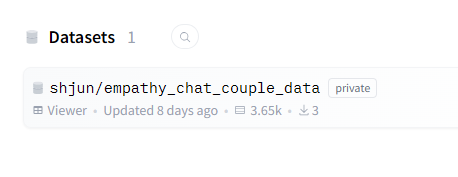

# HuggingFace에서 데이터셋 가져오기

In [ ]:
from datasets import load_dataset
import torch
import numpy as np
from transformers import AutoTokenizer , Trainer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, DataCollatorForLanguageModeling
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    StoppingCriteria,
    StoppingCriteriaList,
)

from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from huggingface_hub import login

# 데이터 셋 가져오기
login(token="token")
data = load_dataset("shjun/empathy_chat_couple_data")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


data.jsonl:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3646 [00:00<?, ? examples/s]

# Base 모델 불러오기 및 양자화 설정

**✅양자화란?**

✔ 데이터의 양자화 (Quantization)은 숫자의 정밀도를 줄여서 모델을 작고 빠르게 만드는 기술


---


**🎯 왜 사용?**

모델이 사용하는 숫자는 보통 **32비트(부동소수점, float32)**이고 이걸 8비트 정수(int8) 같은 낮은 정밀도로 바꾸면:

+ 모델 용량이 줄어들고 (→ 저장 공간 적게 차지)

+ 연산 속도가 빨라지고 (→ 모바일이나 엣지에서 빠르게 동작)

+ 메모리도 덜 먹어 (→ GPU 없이도 가능!)


**✅토큰이란?**

✔ 단어나 문자, 서브워드 등의 작은 단위

✔ 모델이 텍스트를 처리할 수 있도록 숫자로 변환됨



---


**🧠 LLM 모델은 텍스트 자체를 이해하지 못한다!!**

ex. "안녕하세요. 반가워요!"

모델은 텍스트 자체를 이해하지 못하기 때문에 "문자열(텍스트)"이 아니라 "숫자(벡터)"를 받아야함


**✅EOT 토큰**

- Out Of Text : 텍스트의 끝을 의미하는 특수 토큰
- 끝맺음 토큰이라고도 함

✔ LLM 모델은 입력 텍스트가 어디서 끝났는지 알아야 하는데 그걸 알려주는 게 EOT 토큰

✔사람이 보기엔 문장이 끝나면 그냥 끝이지만, 모델은 끝을 명확히 알려줘 함!!



---


**📌 어떤 역할??**


- 학습할 때

- 예측을 멈출 때

- 대화가 끝났음을 나타낼 때

In [ ]:
# 선정 모델
model_id = "yanolja/EEVE-Korean-10.8B-v1.0"

#LoRA와 어울리는 양자화 설정
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})

# 문장의 끝을 나타내는 토큰(End Of Text)
EOT_TOKEN = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.8k [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

# 학습 데이터 확인 및 전처리

- 각 대화를 역할별로 자연스럽게 포맷팅하고 결과적으로 하나의 학습 가능한 text 필드로 생성
- 이 데이터 전처리로 역할별 말하기와 끝맺음 토큰 같이 대화구조를 학습할 수 있음

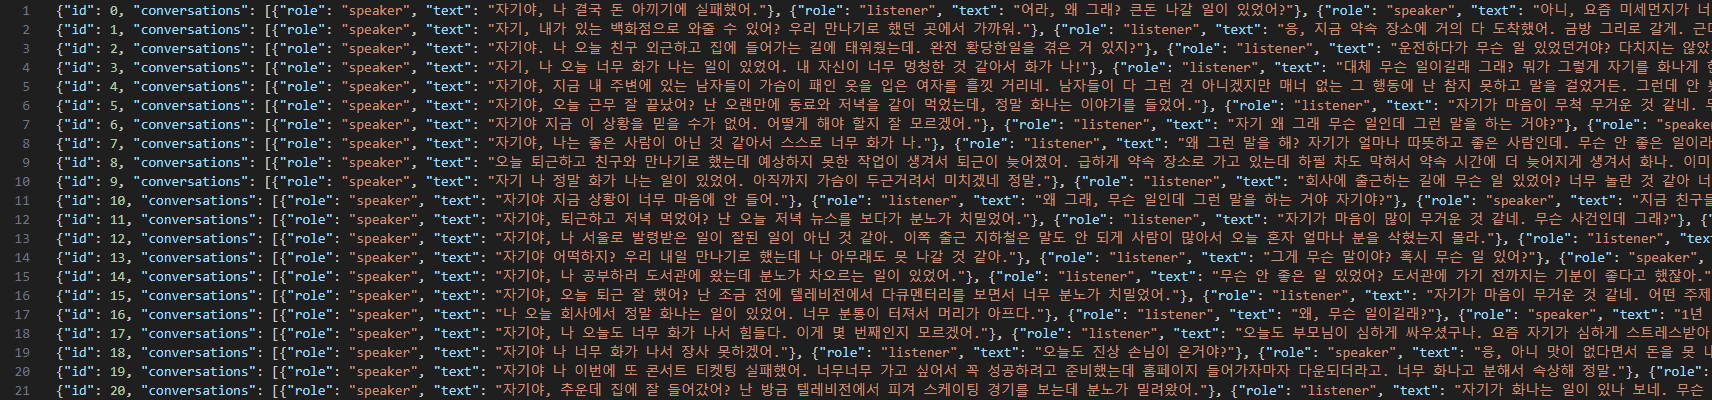

In [ ]:
data['train'][-1]

{'id': 3645,
 'conversations': [{'role': 'speaker', 'text': '자기야, 나 너무 슬퍼서 무기력해.'},
  {'role': 'listener', 'text': '무슨 일 있었어 ?'},
  {'role': 'speaker',
   'text': '새로 산 운동화를 신고 나갔는데 소나기가 와서 흙탕물이 튀었어. 새 신발이 금방 더러워져서 속상해.'},
  {'role': 'listener',
   'text': '아이고, 정말 속상할 수밖에 없는 상황이구나. 새 신발 신는다고 기뻤을 텐데 금방 더러워져서 더 슬플 것 같아.'},
  {'role': 'speaker',
   'text': '응, 나 진짜 새 신발 신고 기뻤었는데 이제는 신발 때문에 너무 슬퍼. 날씨 확인을 못한 내가 바보야.'},
  {'role': 'listener', 'text': '갑자기 내린 소나기였잖아. 예기치 못한 상황을 네 탓으로 돌리면서 슬퍼하지 마.'},
  {'role': 'speaker', 'text': '그렇지만 꼼꼼하지 못한 내 탓도 있는걸. 신발 얼마 신지도 못했는데 세척해야 돼.'},
  {'role': 'listener',
   'text': '자기야, 너무 속상해하지 마. 새 신발을 신으면 신고식으로 한 번씩 밟아준다고 하잖아. 그런 일을 겪었다고 생각하자.'},
  {'role': 'speaker',
   'text': '응, 근데 이번 일은 나 때문에 신발이 금방 더러워진 거라 속상해. 흙탕물을 피할 수도 있었는데 말이야.'},
  {'role': 'listener',
   'text': '아무래도 이미 일어난 일에 아쉬운 점도 많겠지. 하지만 이미 벌어진 일에 계속 슬퍼하기보다는 문제를 해결하는 게 좋지 않을까? 신발을 세척하면 네 기분도 금방 나아질 거야.'},
  {'role': 'speaker', 'text': '응, 자기 말처럼 신발을 세척하면 기분이 나아질까?'},
  {'role': 'listener',


In [ ]:
# 텍스트로 변환
data = data.map(
    lambda x: {
        'text': "\n".join([f"{'여자' if line['role']=='speaker' else '남자'}: {line['text']}{EOT_TOKEN if line['role']!='speaker' else ''}" for line in x['conversations']])
      }
)

# 학습 입력을 토크나이저로 변환
# 텍스트 데이터를 모델이 이해할 수 있는 숫자 형태 즉, 토큰으로 변환한다는 뜻
data = data.map(lambda samples: tokenizer(samples["text"], truncation=True, max_length=2048), batched=True)

Map:   0%|          | 0/3646 [00:00<?, ? examples/s]

Map:   0%|          | 0/3646 [00:00<?, ? examples/s]

### LoRA 파라미터 항목

- r=16 // LoRA rank (저차원 공간의 차원 수)
- lora_alpha=32	// scaling factor
- target_modules // 어떤 모듈에 LoRA를 붙일지 지정 —> EEVE 계열 모델 구조에 특화
- lora_dropout=0 // 드롭아웃 비활성화 —> 안정적 학습
- bias="none" // LoRA에서 bias 학습 안 함
- use_rslora=False //Rank Stabilized LoRA 사용 안 함 (보통 False가 안정적)

### 토큰 설정
- 생성 결과 에서 발화자 구분이 필요할 때, 생성 멈춤 조건을 걸때, 생성 후 후처리 파싱할때 활용하기 위해 미리 확인차 설정
- 각 항목에 대한 숫자는 해당 모델에 학습하며 이미 설정되어 있음

### 학습 파라미터 결과
- all params : 해당 모델의 전체 파라미터 수
- trainable params : 이 중에서 LoRA로 학습 가능한 파라미터 수
- trainable% : 전체 파라미터 중에서서 학습되는 비율

In [ ]:
# Gradient checkpointing 활성화 -> 메모리 최적화 기법
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

# 전체 파라미터 대비 LoRA로 학습되는 파라미터 비율 확인
# 보통 수백억 파라미터 중 수십만 개만 학습(약 0.1%~0.3%)
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

model.gradient_checkpointing_enable()
# LoRA 설정
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_dropout=0,
    bias="none",
    use_rslora = False,
)

# 원본 모델에 LoRA 어댑터 붙이기(trainable 파라미터만 추가)
model = get_peft_model(model, config)
print_trainable_parameters(model)

#역할 토큰 넘버 저장
tokenNum_ai = 33626     # "남자"
tokenNum_human = 33269   # "여자"
tokenNum_com = 714        # ":"

trainable params: 62914560 || all params: 5633347584 || trainable%: 1.1168236836422412


##

## 학습 손실 계산을 재정의

- '남자' 뒤에 나오는 부분만 학습하도록 손실을 마스킹하는 것
- 즉, 모델은 '여자' 뒤의 내용은 예측하지 않도록 -100 마스크를 씌움

In [ ]:
class maskTrainer(Trainer):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def compute_loss(self, model, inputs, return_outputs=False):
    for x in range(len(inputs['labels'])):
      # print(tokenizer.decode(inputs['labels'][x]))

      maskindex1 = (inputs['labels'][x]==tokenNum_human).nonzero()[:, 0].cpu()
      temp = 0
      for i, index in enumerate(maskindex1):
        if (inputs['labels'][x][index+1] != tokenNum_com):
          maskindex1 = np.delete(maskindex1, i-temp)
          temp += 1

      maskindex2 = (inputs['labels'][x]==tokenNum_ai).nonzero()[:, 0].cpu()
      temp = 0
      for i, index in enumerate(maskindex2):
        if (inputs['labels'][x][index+1] != tokenNum_com):
          maskindex2 = np.delete(maskindex2, i-temp)
          temp += 1

      for i in range(len(maskindex1)):
        ai_index = -1
        for num in maskindex2:
          if (maskindex1[i] < num):
            ai_index = num
            break
        if (ai_index == -1):
          inputs['labels'][x][maskindex1[i]+2:] = -100
        else:
          inputs['labels'][x][maskindex1[i]+2:ai_index+2] = -100
    # print(inputs['labels'][x])

    outputs = model(**inputs)
    loss = outputs['loss']
    return (loss,outputs) if return_outputs else loss

# tokenizer.pad_token = tokenizer.eos_token

# 모델 학습 및 파라미터 설정

In [ ]:
NUM_EPOCHS = 2

trainer = Trainer(
    model=model,
    train_dataset=data["train"],
    args=TrainingArguments(
        per_device_train_batch_size=1,    # GPU 1개당 batch 1개
        gradient_accumulation_steps=1,    # 1 step 마다 weight 업데이트
        fp16=True,                        # float16 혼합정밀도 사용 -> 메모리 절약
        output_dir="outputs",             # 체크포인트 저장 위치
        save_total_limit=2,               # 최대 저장 모델 수 2개로 제한
        logging_steps=500,                # 500 step마다 로그 출력
        report_to=["tensorboard"],        # 로그를 텐서보드로 기록
        num_train_epochs = NUM_EPOCHS,    # 2회 학습
        learning_rate=2e-4,               # 비교적 높은 학습률(LoRA에 적합한 수치)
        lr_scheduler_type= "cosine",      # 학습률 점차 감소
    ),
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False
trainer.train()

model.save_pretrained(f"./saved/EVEE/10.8B/{NUM_EPOCHS}epoch")  # 학습이 완료된 모델을 로컬 디렉토리에 저장

No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


# HuggingFace에 push하기

In [ ]:
output_path = f"./saved/EVEE/10.8B/{NUM_EPOCHS}epoch"

model.save_pretrained(output_path)
tokenizer.save_pretrained(output_path)

('./saved/EVEE/10.8B/2epoch/tokenizer_config.json',
 './saved/EVEE/10.8B/2epoch/special_tokens_map.json',
 './saved/EVEE/10.8B/2epoch/tokenizer.json')

In [ ]:
from huggingface_hub import HfApi, HfFolder

repo_id = "shjun/sLLM_empathy_chat_couple"

api = HfApi()
api.create_repo(repo_id=repo_id, repo_type="model", exist_ok=True)

api.upload_folder(
    repo_id=repo_id,
    folder_path=output_path,
    path_in_repo="",
    repo_type="model"
)

adapter_model.safetensors:   0%|          | 0.00/252M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/shjun/sLLM_empathy_chat_couple/commit/dd464a8e69fa67b4f2f450e15a078a05ec90b637', commit_message='Upload folder using huggingface_hub', commit_description='', oid='dd464a8e69fa67b4f2f450e15a078a05ec90b637', pr_url=None, repo_url=RepoUrl('https://huggingface.co/shjun/sLLM_empathy_chat_couple', endpoint='https://huggingface.co', repo_type='model', repo_id='shjun/sLLM_empathy_chat_couple'), pr_revision=None, pr_num=None)

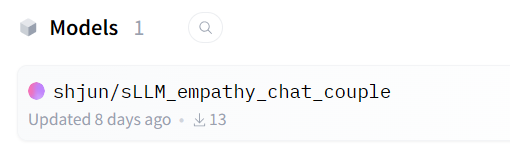